<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

## Load Data

In [ ]:
train_csv = pd.read_csv(
    "data/autass_data2.csv",
    header=None,
    dtype=np.double,
)
data = np.array(train_csv.values[:, 1:50])
del train_csv

In [ ]:
X = data[:, 0:48]
y = data[:, 48].astype(int) - 1

yt = copy.copy(y)
yt[yt == 0] = 20
yt[yt == 1] = 21
yt[yt == 2] = 22
yt[yt == 3] = 23
yt[yt == 4] = 26
yt[yt == 5] = 24
yt[yt == 6] = 27
yt[yt == 7] = 29
yt[yt == 8] = 30
yt[yt == 9] = 25
yt[yt == 10] = 28
yt -= 20
y = yt
del yt

## Config

In [ ]:
epochs = 200
batch_size = 538
lr = 1

## Single Layer

### MLMVN [48-10-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-10-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 10)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_out = OutputLayer(10, 11)
        self.phase_act2 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_out(x)
        x = self.phase_act2(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-10-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-10-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=4c6da71cfc4c498f8da7e410e130c443
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/4c6da71cfc4c498f8da7e410e130c443/output/log
======> WARNING! Git diff to large to store (3944kb), skipping uncommitted changes <======


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-10-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSELoss.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.2798053516728018
Epoch 19 loss is 0.28693026311742914
Epoch 29 loss is 0.2874780130965781
Epoch 39 loss is 0.2984541579734532
Epoch 49 loss is 0.3193280469886697
Epoch 59 loss is 0.33707626521445716
Epoch 69 loss is 0.30040521139203175
Epoch 79 loss is 0.28762346204797534
Epoch 89 loss is 0.31152799377307844
Epoch 99 loss is 0.2576630936111671
Epoch 109 loss is 0.291178549427303
Epoch 119 loss is 0.2490802764713475
Epoch 129 loss is 0.23373190527990692
Epoch 139 loss is 0.28033977577880903
Epoch 149 loss is 0.2837003647392515
Epoch 159 loss is 0.2538141131717079
Epoch 169 loss is 0.3233458041492201
Epoch 179 loss is 0.34501202353519583
Epoch 189 loss is 0.34266169941405217
Epoch 199 loss is 0.3550294292895104
Train Acc.:  0.8201337406798128
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1063
           1       0.85      0.74      0.79      1064
           2       0.96      0.93      0.94      1064
           3  

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.3103850582404919
Epoch 19 loss is 0.2418774839044744
Epoch 29 loss is 0.265908605107625
Epoch 39 loss is 0.2943059382354039
Epoch 49 loss is 0.276436161067747
Epoch 59 loss is 0.32590297383744593
Epoch 69 loss is 0.2767146737255772
Epoch 79 loss is 0.287858186740984
Epoch 89 loss is 0.35907828087177
Epoch 99 loss is 0.4186029191773882
Epoch 109 loss is 0.33285225361643794
Epoch 119 loss is 0.3228767984459741
Epoch 129 loss is 0.35609662567173445
Epoch 139 loss is 0.2398215116127861
Epoch 149 loss is 0.37533755882336206
Epoch 159 loss is 0.3230767278001795
Epoch 169 loss is 0.32038495509949566
Epoch 179 loss is 0.2728121593992897
Epoch 189 loss is 0.23113384043537294
Epoch 199 loss is 0.23697167827133853
Train Acc.:  0.817505928600423
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      1063
           1       0.85      0.72      0.78      1064
           2       0.96      0.92      0.94      1064
           3       0.

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.234435066899149
Epoch 19 loss is 0.23500500804411487
Epoch 29 loss is 0.2704866989198225
Epoch 39 loss is 0.22928027331865544
Epoch 49 loss is 0.24259319125743486
Epoch 59 loss is 0.23993151432124912
Epoch 69 loss is 0.2355228313899169
Epoch 79 loss is 0.29352466112392755
Epoch 89 loss is 0.34534633221051547
Epoch 99 loss is 0.28059194333336157
Epoch 109 loss is 0.3367117756837938
Epoch 119 loss is 0.35539835849532864
Epoch 129 loss is 0.29370534618128263
Epoch 139 loss is 0.2897315933896303
Epoch 149 loss is 0.23595774051726134
Epoch 159 loss is 0.3217572035914341
Epoch 169 loss is 0.3612773694004577
Epoch 179 loss is 0.29780505445589145
Epoch 189 loss is 0.3884432736077841
Epoch 199 loss is 0.5057752075140738
Train Acc.:  0.82641485247933
              precision    recall  f1-score   support

           0       0.74      0.98      0.84      1064
           1       0.87      0.69      0.77      1064
           2       0.96      0.92      0.94      1064
           3  

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.24826095378107285
Epoch 19 loss is 0.22183934458525567
Epoch 29 loss is 0.2376939787540323
Epoch 39 loss is 0.23677890969663506
Epoch 49 loss is 0.19782310665792108
Epoch 59 loss is 0.18985340247155252
Epoch 69 loss is 0.1916335525972637
Epoch 79 loss is 0.1843041258845089
Epoch 89 loss is 0.20625673516565524
Epoch 99 loss is 0.2462787903644629
Epoch 109 loss is 0.3130027202975933
Epoch 119 loss is 0.30493362345149605
Epoch 129 loss is 0.299187534389669
Epoch 139 loss is 0.2979426610025583
Epoch 149 loss is 0.3395869082665093
Epoch 159 loss is 0.3224462941593307
Epoch 169 loss is 0.3119062898221137
Epoch 179 loss is 0.36908871562997664
Epoch 189 loss is 0.36701326872569157
Epoch 199 loss is 0.2913419812224387
Train Acc.:  0.8227829170850514
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1063
           1       0.84      0.91      0.87      1064
           2       0.95      0.91      0.93      1064
           3  

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.23893833129461026
Epoch 19 loss is 0.35352674061561473
Epoch 29 loss is 0.31082288381730555
Epoch 39 loss is 0.28511622276983273
Epoch 49 loss is 0.23868927247854704
Epoch 59 loss is 0.2485950896878176
Epoch 69 loss is 0.41070443044607735
Epoch 79 loss is 0.3084329791560098
Epoch 89 loss is 0.30589607100727806
Epoch 99 loss is 0.3070161200848258
Epoch 109 loss is 0.2976518308637186
Epoch 119 loss is 0.2824108441539807
Epoch 129 loss is 0.3116600160978614
Epoch 139 loss is 0.31757349912205246
Epoch 149 loss is 0.30672799590632993
Epoch 159 loss is 0.40314944724027096
Epoch 169 loss is 0.4096136636855462
Epoch 179 loss is 0.4105623334879551
Epoch 189 loss is 0.44534144032836126
Epoch 199 loss is 0.46514225549527893
Train Acc.:  0.82690623197385
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1064
           1       0.93      0.48      0.64      1064
           2       0.91      0.91      0.91      1064
           3

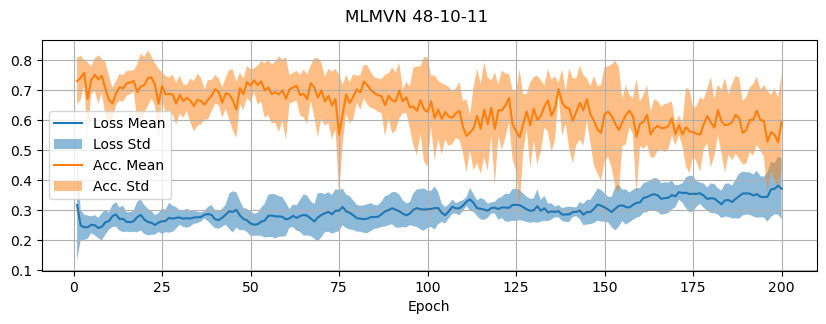

In [ ]:
title = "MLMVN 48-10-11"
image_name = "results/MLMVN_48-10-11.png"
plot_loss_acc_list(title, list_losses, list_scores, image_name)

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-20-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-20-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 20)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_out = OutputLayer(20, 11)
        self.phase_act2 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_out(x)
        x = self.phase_act2(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-20-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-20-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=e9f13dacf8d142619b65b8316ca90780
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/e9f13dacf8d142619b65b8316ca90780/output/log
======> WARNING! Git diff to large to store (3944kb), skipping uncommitted changes <======


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-20-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSELoss.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-20 10:34:58,198 - clearml.frameworks - INFO - Found existing registered model id=c337b94a22444d809d449783726d8ee2 [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-20-11.pt] reusing it.
Epoch 9 loss is 0.16476403157413338
Epoch 19 loss is 0.13633803332426933
Epoch 29 loss is 0.143033463264053
Epoch 39 loss is 0.17849334688199742
Epoch 49 loss is 0.21700776681915424
Epoch 59 loss is 0.2034918992282111
Epoch 69 loss is 0.1712665802112372
Epoch 79 loss is 0.20085534461565652
Epoch 89 loss is 0.2502123033688426
Epoch 99 loss is 0.30439372755517824
Epoch 109 loss is 0.3093228314198623
Epoch 119 loss is 0.27491323067701007
Epoch 129 loss is 0.28011414414391217
Epoch 139 loss is 0.3747490415384792
Epoch 149 loss is 0.27613471357266345
Epoch 159 loss is 0.23981115046878665
Epoch 169 loss is 0.2038788837831156
Epoch 179 loss is 0.18847714759522705
Epoch 189 loss is 0.2114042358851922
Epoch 199 loss is 0.20061396634221004
Train Acc.:  0.8892473348003503
     

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.16358843200535636
Epoch 19 loss is 0.2041445672195862
Epoch 29 loss is 0.24642286260837112
Epoch 39 loss is 0.19917514925837854
Epoch 49 loss is 0.25327855214060685
Epoch 59 loss is 0.21884971568181918
Epoch 69 loss is 0.22624078805323974
Epoch 79 loss is 0.26295991330810126
Epoch 89 loss is 0.22422218505461025
Epoch 99 loss is 0.2339717792959955
Epoch 109 loss is 0.19874802368569566
Epoch 119 loss is 0.23704211230309438
Epoch 129 loss is 0.24084612126041485
Epoch 139 loss is 0.20031062393464874
Epoch 149 loss is 0.18938521056672464
Epoch 159 loss is 0.20100549875098014
Epoch 169 loss is 0.20972725948272172
Epoch 179 loss is 0.20063395868672673
Epoch 189 loss is 0.183422525811785
Epoch 199 loss is 0.1669537319356945
Train Acc.:  0.8925374409810498
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1063
           1       0.90      0.87      0.88      1064
           2       0.99      0.97      0.98      1064
       

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.19744827084414995
Epoch 19 loss is 0.20472359266774093
Epoch 29 loss is 0.2544472813758418
Epoch 39 loss is 0.19045720603945143
Epoch 49 loss is 0.20343276143970507
Epoch 59 loss is 0.22297812880413134
Epoch 69 loss is 0.22178893715622944
Epoch 79 loss is 0.2498799044945237
Epoch 89 loss is 0.22153046921128713
Epoch 99 loss is 0.23420279826211265
Epoch 109 loss is 0.22040926507985742
Epoch 119 loss is 0.21762960224465708
Epoch 129 loss is 0.2605731742439022
Epoch 139 loss is 0.2775670812423578
Epoch 149 loss is 0.19603989313909037
Epoch 159 loss is 0.20545349137968197
Epoch 169 loss is 0.20606501781890182
Epoch 179 loss is 0.18431993443444303
Epoch 189 loss is 0.1741126129084759
Epoch 199 loss is 0.1724068336751827
Train Acc.:  0.8685025744012648
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1064
           1       0.92      0.75      0.82      1064
           2       0.96      0.94      0.95      1064
        

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.18983226445452947
Epoch 19 loss is 0.20989331423949678
Epoch 29 loss is 0.20457408459425253
Epoch 39 loss is 0.21686740636756055
Epoch 49 loss is 0.1686385065915988
Epoch 59 loss is 0.15638486085080838
Epoch 69 loss is 0.1741827037910428
Epoch 79 loss is 0.1640841394764191
Epoch 89 loss is 0.17007600609779142
Epoch 99 loss is 0.19284076037560408
Epoch 109 loss is 0.19138844241490113
Epoch 119 loss is 0.20478322070718535
Epoch 129 loss is 0.21176829993640264
Epoch 139 loss is 0.22802495808894305
Epoch 149 loss is 0.2164955049311736
Epoch 159 loss is 0.2058771283183833
Epoch 169 loss is 0.17439026342796043
Epoch 179 loss is 0.19134460117948338
Epoch 189 loss is 0.17625964681553905
Epoch 199 loss is 0.21366730862193598
Train Acc.:  0.8870895378896319
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1063
           1       0.87      0.89      0.88      1064
           2       0.93      0.97      0.95      1064
       

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.17402481484483856
Epoch 19 loss is 0.1944497671217645
Epoch 29 loss is 0.14842624541281338
Epoch 39 loss is 0.15502097794515227
Epoch 49 loss is 0.15759596208770407
Epoch 59 loss is 0.19170838004354154
Epoch 69 loss is 0.1871364349827201
Epoch 79 loss is 0.18722396261041316
Epoch 89 loss is 0.1876739674177174
Epoch 99 loss is 0.2193864859799957
Epoch 109 loss is 0.19671043294002857
Epoch 119 loss is 0.22702499457486658
Epoch 129 loss is 0.21129339398637728
Epoch 139 loss is 0.2182856933389895
Epoch 149 loss is 0.21264683162737122
Epoch 159 loss is 0.20315929596125387
Epoch 169 loss is 0.18449427099611365
Epoch 179 loss is 0.1783611846088383
Epoch 189 loss is 0.18641298905492973
Epoch 199 loss is 0.17783021613349564
Train Acc.:  0.8899737218792061
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1064
           1       0.88      0.80      0.84      1064
           2       0.96      0.97      0.97      1064
        

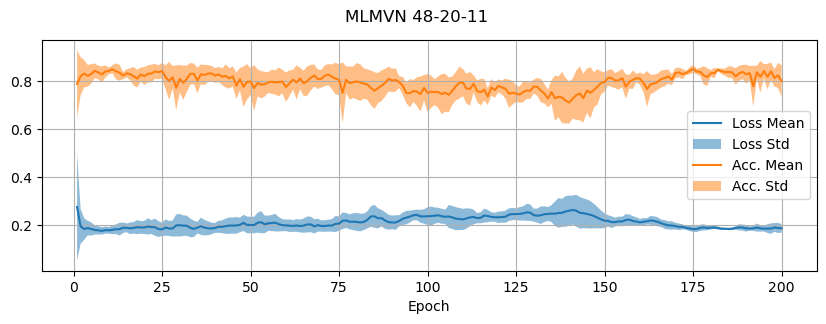

In [ ]:
title = "MLMVN 48-20-11"
image_name = "results/MLMVN_48-20-11.png"
plot_loss_acc_list(title, list_losses, list_scores, image_name)

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-50-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-50-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 50)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_out = OutputLayer(50, 11)
        self.phase_act2 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_out(x)
        x = self.phase_act2(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-50-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-50-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=3560d2ef7d5a41718f94259373e7966c
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/3560d2ef7d5a41718f94259373e7966c/output/log
======> WARNING! Git diff to large to store (3944kb), skipping uncommitted changes <======


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-50-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSELoss.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-20 10:50:33,334 - clearml.frameworks - INFO - Found existing registered model id=bb96e63090904339bf87c4852d30bdb6 [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-50-11.pt] reusing it.
Epoch 9 loss is 0.09829269534206735
Epoch 19 loss is 0.09728068709222959
Epoch 29 loss is 0.07600427848917563
Epoch 39 loss is 0.060900669434152684
Epoch 49 loss is 0.06557708991894179
Epoch 59 loss is 0.0620218198349882
Epoch 69 loss is 0.055180916741809694
Epoch 79 loss is 0.05770168026537519
Epoch 89 loss is 0.06312691609980167
Epoch 99 loss is 0.06258158094408227
Epoch 109 loss is 0.06726164969189814
Epoch 119 loss is 0.053113842805941974
Epoch 129 loss is 0.05192851680713503
Epoch 139 loss is 0.07066245038442918
Epoch 149 loss is 0.0635699498573305
Epoch 159 loss is 0.05401376535508686
Epoch 169 loss is 0.06267989696299203
Epoch 179 loss is 0.08033388429254887
Epoch 189 loss is 0.06335794221812717
Epoch 199 loss is 0.0672287838247473
Train Acc.:  0.9651975131924

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.0493437117112904
Epoch 19 loss is 0.056332634788183775
Epoch 29 loss is 0.04848900109983579
Epoch 39 loss is 0.052226300307049216
Epoch 49 loss is 0.06732437820930277
Epoch 59 loss is 0.06013609383791088
Epoch 69 loss is 0.06488484996680653
Epoch 79 loss is 0.07402341604512623
Epoch 89 loss is 0.06415823828871538
Epoch 99 loss is 0.07401829229000033
Epoch 109 loss is 0.07514582485574416
Epoch 119 loss is 0.08362585630122568
Epoch 129 loss is 0.08486246263407854
Epoch 139 loss is 0.07425523240837605
Epoch 149 loss is 0.08443371962698622
Epoch 159 loss is 0.09720449556099098
Epoch 169 loss is 0.10067659587005852
Epoch 179 loss is 0.1193294871778844
Epoch 189 loss is 0.10106213514554797
Epoch 199 loss is 0.09858312506276698
Train Acc.:  0.9670134808896105
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1063
           1       0.96      0.96      0.96      1064
           2       1.00      0.99      0.99      1064
  

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.048120356670683234
Epoch 19 loss is 0.054593459310181086
Epoch 29 loss is 0.05499350411994715
Epoch 39 loss is 0.0559697642856175
Epoch 49 loss is 0.05754442725054534
Epoch 59 loss is 0.061489513417114956
Epoch 69 loss is 0.07086944463691781
Epoch 79 loss is 0.07706030743617291
Epoch 89 loss is 0.07593725247272468
Epoch 99 loss is 0.0732947676897344
Epoch 109 loss is 0.07531350286253687
Epoch 119 loss is 0.0911661580282024
Epoch 129 loss is 0.11443896325586743
Epoch 139 loss is 0.10335307976202589
Epoch 149 loss is 0.10366860029550481
Epoch 159 loss is 0.09899129316663502
Epoch 169 loss is 0.10486127629475518
Epoch 179 loss is 0.11867640283355274
Epoch 189 loss is 0.12511503382191627
Epoch 199 loss is 0.11799590483737314
Train Acc.:  0.9631679022368449
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1064
           1       0.96      0.94      0.95      1064
           2       0.99      0.98      0.99      1064
  

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.05517547633181337
Epoch 19 loss is 0.055728762308260765
Epoch 29 loss is 0.06259614482605945
Epoch 39 loss is 0.0581895142248359
Epoch 49 loss is 0.06561329385021032
Epoch 59 loss is 0.07032996307126822
Epoch 69 loss is 0.08136375973696794
Epoch 79 loss is 0.11977187777366366
Epoch 89 loss is 0.084233777680467
Epoch 99 loss is 0.09336862232729168
Epoch 109 loss is 0.10234290900702865
Epoch 119 loss is 0.14733771738094092
Epoch 129 loss is 0.13079876845970226
Epoch 139 loss is 0.11238334142687469
Epoch 149 loss is 0.12448816318563458
Epoch 159 loss is 0.11167881321193102
Epoch 169 loss is 0.10511961659141926
Epoch 179 loss is 0.10364262851145377
Epoch 189 loss is 0.10639918512951829
Epoch 199 loss is 0.09649024979717642
Train Acc.:  0.9571431623475122
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1063
           1       0.95      0.94      0.95      1064
           2       0.99      0.99      0.99      1064
    

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.0682420963425835
Epoch 19 loss is 0.06717379428891208
Epoch 29 loss is 0.059015318733788666
Epoch 39 loss is 0.06176190170409206
Epoch 49 loss is 0.07237386654932479
Epoch 59 loss is 0.06911019201668694
Epoch 69 loss is 0.06392903645561016
Epoch 79 loss is 0.0758716126534257
Epoch 89 loss is 0.07730068602143042
Epoch 99 loss is 0.09665151482480443
Epoch 109 loss is 0.09222695319517936
Epoch 119 loss is 0.08182469168154197
Epoch 129 loss is 0.08335947978406187
Epoch 139 loss is 0.09159492862302886
Epoch 149 loss is 0.0906091966868739
Epoch 159 loss is 0.0885280304984252
Epoch 169 loss is 0.09157913406478384
Epoch 179 loss is 0.09323288036652193
Epoch 189 loss is 0.08298648299531121
Epoch 199 loss is 0.09408725998949831
Train Acc.:  0.95340440532399
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1064
           1       0.98      0.87      0.92      1064
           2       1.00      0.99      0.99      1064
       

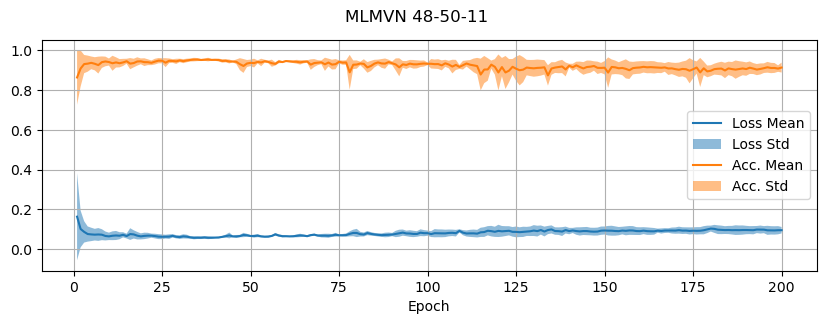

In [ ]:
title = "MLMVN 48-50-11"
image_name = "results/MLMVN_48-50-11.png"
plot_loss_acc_list(title, list_losses, list_scores, image_name)

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-100-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-100-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 100)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_out = OutputLayer(100, 11)
        self.phase_act2 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_out(x)
        x = self.phase_act2(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-100-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-100-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=054b29d2a004437ca390c9553dc79f1d
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/054b29d2a004437ca390c9553dc79f1d/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-100-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSELoss.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_1728/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-29 15:23:48,722 - clearml.frameworks - INFO - Found existing registered model id=0f73e6db01fc42988672e4f44c0add5f [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-100-11.pt] reusing it.
Epoch 9 loss is 0.09289930875531222
Epoch 19 loss is 0.07704454008271648
Epoch 29 loss is 0.05779679460027949
Epoch 39 loss is 0.054986268708860524
Epoch 49 loss is 0.04733543763708861
Epoch 59 loss is 0.042054025328116786
Epoch 69 loss is 0.0412137783292874
Epoch 79 loss is 0.038980292259018084
Epoch 89 loss is 0.04195052638688717
Epoch 99 loss is 0.04400554969643017
Epoch 109 loss is 0.03583445803540681
Epoch 119 loss is 0.031936028648656224
Epoch 129 loss is 0.03988531487611844
Epoch 139 loss is 0.03480796749345809
Epoch 149 loss is 0.02863502808161461
Epoch 159 loss is 0.03285262207237886
Epoch 169 loss is 0.03205184485479631
Epoch 179 loss is 0.030309476964466488
Epoch 189 loss is 0.031384972778109824
Epoch 199 loss is 0.03278481486374329
Train Acc.:  0.9800884

ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


/tmp/ipykernel_1728/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.09651948221217745
Epoch 19 loss is 0.08151637139831774
Epoch 29 loss is 0.06691473724981084
Epoch 39 loss is 0.06491206984382683
Epoch 49 loss is 0.052847569881330464
Epoch 59 loss is 0.06549010836655457
Epoch 69 loss is 0.049922240791715526
Epoch 79 loss is 0.04560603635225597
Epoch 89 loss is 0.04709434644222514
Epoch 99 loss is 0.09155044545100574
Epoch 109 loss is 0.05177482526370294
Epoch 119 loss is 0.045173095736625105
Epoch 129 loss is 0.041602230912906296
Epoch 139 loss is 0.04224502944542365
Epoch 149 loss is 0.03876666575995179
Epoch 159 loss is 0.04185715320046077
Epoch 169 loss is 0.03916762878300975
Epoch 179 loss is 0.04057138104183288
Epoch 189 loss is 0.036145847549370606
Epoch 199 loss is 0.034255525449209644
Train Acc.:  0.9715640822953832
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1063
           1       0.95      0.94      0.95      1064
           2       1.00      0.99      0.99      1

/tmp/ipykernel_1728/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.10197848648032753
Epoch 19 loss is 0.06620522870230666
Epoch 29 loss is 0.060791586014725764
Epoch 39 loss is 0.044058532288178125
Epoch 49 loss is 0.049066377845850113
Epoch 59 loss is 0.041483171210737656
Epoch 69 loss is 0.041699789178138276
Epoch 79 loss is 0.04010221614370895
Epoch 89 loss is 0.04200853150707565
Epoch 99 loss is 0.03748572558613685
Epoch 109 loss is 0.03339820400178514
Epoch 119 loss is 0.03418882536913687
Epoch 129 loss is 0.0396406334017026
Epoch 139 loss is 0.034145767822064424
Epoch 149 loss is 0.031575263631362274
Epoch 159 loss is 0.03257143025928933
Epoch 169 loss is 0.02900946434349241
Epoch 179 loss is 0.02646721908453089
Epoch 189 loss is 0.0283171769401771
Epoch 199 loss is 0.02924505333332722
Train Acc.:  0.982673531736706
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1064
           1       0.96      0.94      0.95      1064
           2       1.00      0.99      0.99      106

/tmp/ipykernel_1728/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.0941163479264211
Epoch 19 loss is 0.07211157489541835
Epoch 29 loss is 0.054892876686113645
Epoch 39 loss is 0.04960960956649523
Epoch 49 loss is 0.05018771907397448
Epoch 59 loss is 0.042637427155138234
Epoch 69 loss is 0.04489222136725094
Epoch 79 loss is 0.04308418388475778
Epoch 89 loss is 0.036878224414511725
Epoch 99 loss is 0.040199719304018
Epoch 109 loss is 0.036902204839538835
Epoch 119 loss is 0.0691947571347315
Epoch 129 loss is 0.030887174296426335
Epoch 139 loss is 0.03259241320497548
Epoch 149 loss is 0.028693328512752206
Epoch 159 loss is 0.031290255170440935
Epoch 169 loss is 0.03944383013459841
Epoch 179 loss is 0.028000841225022752
Epoch 189 loss is 0.02779464459963016
Epoch 199 loss is 0.02589195430212821
Train Acc.:  0.9802807272416519
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1063
           1       0.96      0.96      0.96      1064
           2       1.00      0.99      0.99      106

/tmp/ipykernel_1728/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.09346566112894616
Epoch 19 loss is 0.06853978841650973
Epoch 29 loss is 0.06052018883336245
Epoch 39 loss is 0.05080707795295913
Epoch 49 loss is 0.04300807335716183
Epoch 59 loss is 0.04929946212015129
Epoch 69 loss is 0.03806456857102248
Epoch 79 loss is 0.038455738981116754
Epoch 89 loss is 0.03478891861672422
Epoch 99 loss is 0.03865558608219994
Epoch 109 loss is 0.03655600548813174
Epoch 119 loss is 0.03847341857153493
Epoch 129 loss is 0.03406350920763785
Epoch 139 loss is 0.028289964899613603
Epoch 149 loss is 0.03063547244197927
Epoch 159 loss is 0.03108327055907574
Epoch 169 loss is 0.02898037821549324
Epoch 179 loss is 0.033139572848924596
Epoch 189 loss is 0.03204601005634074
Epoch 199 loss is 0.036471306994475566
Train Acc.:  0.9812207575789946
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1064
           1       0.96      0.95      0.95      1064
           2       0.99      0.99      0.99      106

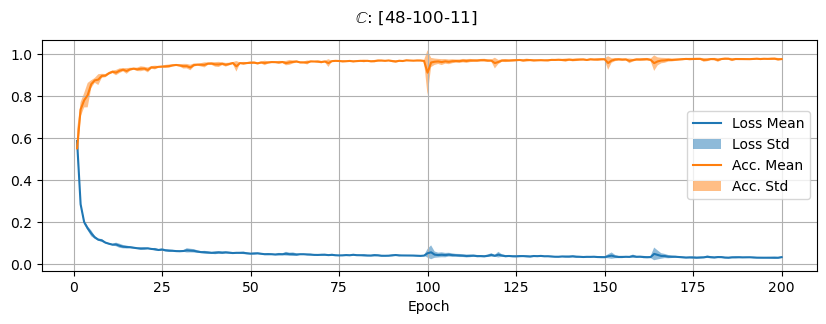

In [ ]:
# title = "MLMVN 48-100-11"
# image_name = "results/MLMVN_48-100-11.png"
# plot_loss_acc_list(title, list_losses, list_scores, image_name)
plot_loss_acc_list(
    "$\mathbb{C}$: [48-100-11] ", list_losses, list_scores, "mlmvn-48-100-11.png"
)

In [ ]:
task.mark_completed()
task.close()

## Multi Layer

### MLMVN [48-10-10-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-10-10-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 10)
        self.phase_act1 = cmplx_phase_activation()
        self.hidden_layer = HiddenLayer(10, 10)
        self.phase_act2 = cmplx_phase_activation()
        self.linear_out = OutputLayer(10, 11)
        self.phase_act3 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.hidden_layer_hook_handle = self.hidden_layer.register_full_backward_hook(
            self.hidden_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.hidden_layer(x)
        x = self.phase_act2(x)
        x = self.linear_out(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-10-10-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-10-10-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=e9ee3195207b4491b042a3263013a77e
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/e9ee3195207b4491b042a3263013a77e/output/log
======> WARNING! Git diff to large to store (3945kb), skipping uncommitted changes <======


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-10-10-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSELoss.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-20 11:47:55,893 - clearml.frameworks - INFO - Found existing registered model id=410edb2915b24269b7d34f2e38593dff [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-10-10-11.pt] reusing it.
Epoch 9 loss is 0.6826655212453996
Epoch 19 loss is 0.6434948379370677
Epoch 29 loss is 1.682729382474014
Epoch 39 loss is 0.8484829522237753
Epoch 49 loss is 0.9924725228800226
Epoch 59 loss is 1.225485459978534
Epoch 69 loss is 1.2029846038520795
Epoch 79 loss is 1.099226063781701
Epoch 89 loss is 1.0669221436146312
Epoch 99 loss is 1.107601797709253
Epoch 109 loss is 1.154826187850244
Epoch 119 loss is 1.1937538569152097
Epoch 129 loss is 1.326074848158841
Epoch 139 loss is 1.3625349669490228
Epoch 149 loss is 1.416390194581627
Epoch 159 loss is 1.4488717111937812
Epoch 169 loss is 1.4282188851979989
Epoch 179 loss is 1.3428309118204484
Epoch 189 loss is 1.3047422414686045
Epoch 199 loss is 1.2980417729564269
Train Acc.:  0.2878629264853548
              precis

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.6345554160230358
Epoch 19 loss is 0.6341311608846562
Epoch 29 loss is 0.6275105257557847
Epoch 39 loss is 0.5689082943180627
Epoch 49 loss is 0.6202519709362332
Epoch 59 loss is 0.5899542082300644
Epoch 69 loss is 0.6059699475133334
Epoch 79 loss is 0.6356775981652049
Epoch 89 loss is 0.6037438777306993
Epoch 99 loss is 0.6510460628543737
Epoch 109 loss is 0.6542612130467913
Epoch 119 loss is 0.6918248563732031
Epoch 129 loss is 0.7057371972704083
Epoch 139 loss is 0.6756918212281602
Epoch 149 loss is 0.7112479285104816
Epoch 159 loss is 0.7220244566123118
Epoch 169 loss is 0.6584324293919726
Epoch 179 loss is 0.677293022265238
Epoch 189 loss is 0.732903885474247
Epoch 199 loss is 0.6873554666623318
Train Acc.:  0.19435127224560428
              precision    recall  f1-score   support

           0       0.65      0.86      0.74      1063
           1       0.60      0.11      0.18      1064
           2       1.00      0.00      0.00      1064
           3       0.71

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.5564281727099429
Epoch 19 loss is 0.6418290258673861
Epoch 29 loss is 0.5871009681556589
Epoch 39 loss is 0.5831930390706477
Epoch 49 loss is 0.5565574083864082
Epoch 59 loss is 0.564178441950088
Epoch 69 loss is 0.6094082608646254
Epoch 79 loss is 0.6089586009663431
Epoch 89 loss is 0.5983078625392015
Epoch 99 loss is 0.5945027639119206
Epoch 109 loss is 0.6506962952883656
Epoch 119 loss is 0.7257264045269749
Epoch 129 loss is 0.678212085055888
Epoch 139 loss is 0.6776558524296338
Epoch 149 loss is 0.7104895346845802
Epoch 159 loss is 0.6882588813485881
Epoch 169 loss is 0.7179067223460094
Epoch 179 loss is 0.7732332268676302
Epoch 189 loss is 0.6688145327155556
Epoch 199 loss is 0.7576797799143649
Train Acc.:  0.35227636891917874
              precision    recall  f1-score   support

           0       0.69      0.91      0.78      1064
           1       0.63      0.14      0.23      1064
           2       0.54      0.05      0.08      1064
           3       0.73

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.5662067563710496
Epoch 19 loss is 0.6213271730355293
Epoch 29 loss is 0.654203641457264
Epoch 39 loss is 0.6337888713462974
Epoch 49 loss is 0.6457664152151374
Epoch 59 loss is 0.6597888498208774
Epoch 69 loss is 0.6427117237528076
Epoch 79 loss is 0.6644485126309694
Epoch 89 loss is 0.6497885471919859
Epoch 99 loss is 0.664900713379054
Epoch 109 loss is 0.7335350312946143
Epoch 119 loss is 0.6744735994675508
Epoch 129 loss is 0.6019557783170132
Epoch 139 loss is 0.6643925186955931
Epoch 149 loss is 0.6978280461548153
Epoch 159 loss is 0.7079139499893651
Epoch 169 loss is 0.7004879680163926
Epoch 179 loss is 0.6955539259637074
Epoch 189 loss is 0.7227160645393367
Epoch 199 loss is 0.7013177086430019
Train Acc.:  0.30412117845621384
              precision    recall  f1-score   support

           0       0.89      0.70      0.78      1063
           1       0.69      0.03      0.05      1064
           2       0.40      0.00      0.01      1064
           3       0.29

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.6462013213971773
Epoch 19 loss is 0.6389570948507705
Epoch 29 loss is 0.6302553856908272
Epoch 39 loss is 0.6686538271036292
Epoch 49 loss is 0.6319803249955375
Epoch 59 loss is 0.6704890164284341
Epoch 69 loss is 0.6675763220336224
Epoch 79 loss is 0.6127046239510358
Epoch 89 loss is 0.6306565278537534
Epoch 99 loss is 0.6080596561205306
Epoch 109 loss is 0.6252069135156932
Epoch 119 loss is 0.6703968429372862
Epoch 129 loss is 0.6282122259810444
Epoch 139 loss is 0.6578433907832637
Epoch 149 loss is 0.6300546160158725
Epoch 159 loss is 0.6349844848961109
Epoch 169 loss is 0.660426835785601
Epoch 179 loss is 0.6781952575179441
Epoch 189 loss is 0.7636298837766232
Epoch 199 loss is 0.7090256706323586
Train Acc.:  0.26226846411861476
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1064
           1       0.00      0.00      0.00      1064
           2       0.40      0.00      0.00      1064
           3       0.0

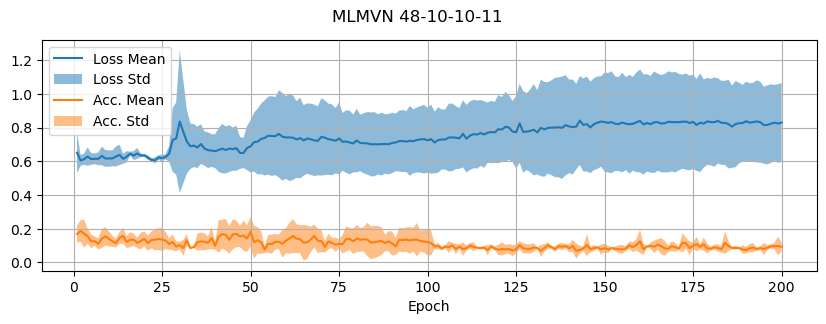

In [ ]:
title = "MLMVN 48-10-10-11"
image_name = "results/MLMVN_48-10-10-11.png"
plot_loss_acc_list(title, list_losses, list_scores, image_name)

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-20-20-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-20-20-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 20)
        self.phase_act1 = cmplx_phase_activation()
        self.hidden_layer = HiddenLayer(20, 20)
        self.phase_act2 = cmplx_phase_activation()
        self.linear_out = OutputLayer(20, 11)
        self.phase_act3 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.hidden_layer_hook_handle = self.hidden_layer.register_full_backward_hook(
            self.hidden_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.hidden_layer(x)
        x = self.phase_act2(x)
        x = self.linear_out(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-20-20-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-20-20-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=a3eff1625a2248499f654e9c4acbc249
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/a3eff1625a2248499f654e9c4acbc249/output/log
======> WARNING! Git diff to large to store (3945kb), skipping uncommitted changes <======


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-20-20-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSELoss.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-20 12:08:56,112 - clearml.frameworks - INFO - Found existing registered model id=22ba5a4169ed406a9e74f40200bd29a1 [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-20-20-11.pt] reusing it.
Epoch 9 loss is 0.45985028386046645
Epoch 19 loss is 0.46694517354238074
Epoch 29 loss is 0.5138218233961965
Epoch 39 loss is 0.489275320767695
Epoch 49 loss is 0.46309303163233473
Epoch 59 loss is 0.5043632157724234
Epoch 69 loss is 0.5141429366918676
Epoch 79 loss is 0.5218683561772139
Epoch 89 loss is 0.5066106861905705
Epoch 99 loss is 0.4761282653118995
Epoch 109 loss is 0.49827079538493996
Epoch 119 loss is 0.48505905692880175
Epoch 129 loss is 0.5079328540396203
Epoch 139 loss is 0.5163228861017134
Epoch 149 loss is 0.5224325401679479
Epoch 159 loss is 0.5032478966871081
Epoch 169 loss is 0.5706603788963629
Epoch 179 loss is 0.5139070999296187
Epoch 189 loss is 0.5066333485208855
Epoch 199 loss is 0.5263176922877412
Train Acc.:  0.6204200226461855
         

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.5688516497621854
Epoch 19 loss is 0.5853694274411174
Epoch 29 loss is 0.5336314268039691
Epoch 39 loss is 0.5259366272492032
Epoch 49 loss is 0.4406968322599601
Epoch 59 loss is 0.4602583709539878
Epoch 69 loss is 0.422908938931125
Epoch 79 loss is 0.38922475710926
Epoch 89 loss is 0.37434202443270037
Epoch 99 loss is 0.41176429432307965
Epoch 109 loss is 0.4118744091051351
Epoch 119 loss is 0.4045098062961893
Epoch 129 loss is 0.3924032459478811
Epoch 139 loss is 0.3417262166598632
Epoch 149 loss is 0.3713361415147345
Epoch 159 loss is 0.41062360966720174
Epoch 169 loss is 0.4235746380622734
Epoch 179 loss is 0.440063917933553
Epoch 189 loss is 0.4052802512719287
Epoch 199 loss is 0.42583715747994355
Train Acc.:  0.5227636891917875
              precision    recall  f1-score   support

           0       0.92      0.67      0.78      1063
           1       0.77      0.70      0.73      1064
           2       0.80      0.54      0.64      1064
           3       0.7

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.47377377477567517
Epoch 19 loss is 0.5818123642246609
Epoch 29 loss is 0.5524255425898911
Epoch 39 loss is 0.5331408636790176
Epoch 49 loss is 0.5266223084583397
Epoch 59 loss is 0.5084204272973452
Epoch 69 loss is 0.5221864123225712
Epoch 79 loss is 0.5321368323514395
Epoch 89 loss is 0.514046891010893
Epoch 99 loss is 0.5044625116486476
Epoch 109 loss is 0.511035881480326
Epoch 119 loss is 0.4235200404283216
Epoch 129 loss is 0.4491360122023273
Epoch 139 loss is 0.4383623463237392
Epoch 149 loss is 0.4002990811088816
Epoch 159 loss is 0.4750563005024748
Epoch 169 loss is 0.49327760079269994
Epoch 179 loss is 0.4378667111784329
Epoch 189 loss is 0.4289851294534545
Epoch 199 loss is 0.44141732628824326
Train Acc.:  0.6061486529792552
              precision    recall  f1-score   support

           0       0.74      0.96      0.83      1064
           1       0.83      0.75      0.79      1064
           2       0.86      0.61      0.71      1064
           3       0.

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.5850991051083132
Epoch 19 loss is 0.5139111042576086
Epoch 29 loss is 0.5051983122342294
Epoch 39 loss is 0.4890419324490173
Epoch 49 loss is 0.4791715259888635
Epoch 59 loss is 0.47829466650556235
Epoch 69 loss is 0.5754105911410774
Epoch 79 loss is 0.5353490414692079
Epoch 89 loss is 0.5049187065218432
Epoch 99 loss is 0.4971644238685353
Epoch 109 loss is 0.5064778615772576
Epoch 119 loss is 0.4903276163818602
Epoch 129 loss is 0.5342514048885157
Epoch 139 loss is 0.5082254582992605
Epoch 149 loss is 0.5033399215026231
Epoch 159 loss is 0.5054516411753327
Epoch 169 loss is 0.49747021993098295
Epoch 179 loss is 0.5080253523201269
Epoch 189 loss is 0.5288063903208304
Epoch 199 loss is 0.5138201494084611
Train Acc.:  0.4667250624906531
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1063
           1       0.72      0.57      0.64      1064
           2       0.92      0.27      0.42      1064
           3       0

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.43746739830786185
Epoch 19 loss is 0.5063128960291862
Epoch 29 loss is 0.5443279274534242
Epoch 39 loss is 0.5534543733837946
Epoch 49 loss is 0.5142911469330737
Epoch 59 loss is 0.48123787249991384
Epoch 69 loss is 0.4897241118216021
Epoch 79 loss is 0.486641422076389
Epoch 89 loss is 0.4709927596896531
Epoch 99 loss is 0.5305603540484453
Epoch 109 loss is 0.5086426096428968
Epoch 119 loss is 0.5261937886370114
Epoch 129 loss is 0.5249747488613029
Epoch 139 loss is 0.5480216689726441
Epoch 149 loss is 0.5228087067398941
Epoch 159 loss is 0.4817364265776811
Epoch 169 loss is 0.4622485672858562
Epoch 179 loss is 0.49610587677871815
Epoch 189 loss is 0.4783234726880176
Epoch 199 loss is 0.4741022823045306
Train Acc.:  0.5234900762706433
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1064
           1       1.00      0.01      0.01      1064
           2       0.82      0.16      0.26      1064
           3       0

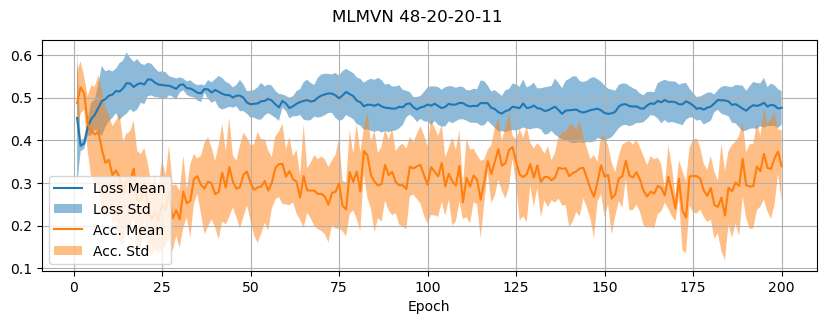

In [ ]:
title = "MLMVN 48-20-20-11"
image_name = "results/MLMVN_48-20-20-11.png"
plot_loss_acc_list(title, list_losses, list_scores, image_name)

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-50-50-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-50-50-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 50)
        self.phase_act1 = cmplx_phase_activation()
        self.hidden_layer = HiddenLayer(50, 50)
        self.phase_act2 = cmplx_phase_activation()
        self.linear_out = OutputLayer(50, 11)
        self.phase_act3 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.hidden_layer_hook_handle = self.hidden_layer.register_full_backward_hook(
            self.hidden_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.hidden_layer(x)
        x = self.phase_act2(x)
        x = self.linear_out(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-50-50-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-50-50-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=2e5cbed78f624d038cdcebb083f902fd
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/2e5cbed78f624d038cdcebb083f902fd/output/log
======> WARNING! Git diff to large to store (3945kb), skipping uncommitted changes <======


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-50-50-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSELoss.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-20 12:31:47,473 - clearml.frameworks - INFO - Found existing registered model id=f13061c5d03a4e96b788becd5e54443a [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-50-50-11.pt] reusing it.
Epoch 9 loss is 0.18509080590032817
Epoch 19 loss is 0.29851992221797385
Epoch 29 loss is 0.38003938826666434
Epoch 39 loss is 0.35283929485604354
Epoch 49 loss is 0.36427067316960327
Epoch 59 loss is 0.31956071771618505
Epoch 69 loss is 0.2919854808615466
Epoch 79 loss is 0.26728589118038387
Epoch 89 loss is 0.2505744858820967
Epoch 99 loss is 0.24366257508408273
Epoch 109 loss is 0.2526296646400297
Epoch 119 loss is 0.2543207117758536
Epoch 129 loss is 0.24703290146744958
Epoch 139 loss is 0.24847459500962163
Epoch 149 loss is 0.24224065429443592
Epoch 159 loss is 0.2280505035935983
Epoch 169 loss is 0.22783374165114506
Epoch 179 loss is 0.22949014620485136
Epoch 189 loss is 0.2128073209289787
Epoch 199 loss is 0.21034013310932373
Train Acc.:  0.8228683743884462

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.2861229127408851
Epoch 19 loss is 0.3707694820754066
Epoch 29 loss is 0.4135629910389318
Epoch 39 loss is 0.4015215646610006
Epoch 49 loss is 0.3934166022651121
Epoch 59 loss is 0.37682299911311523
Epoch 69 loss is 0.32850649921225733
Epoch 79 loss is 0.3117090487146507
Epoch 89 loss is 0.3013186492740078
Epoch 99 loss is 0.2815918980042734
Epoch 109 loss is 0.3025606700072974
Epoch 119 loss is 0.29640244765806867
Epoch 129 loss is 0.2886136706741845
Epoch 139 loss is 0.27816065918712707
Epoch 149 loss is 0.27148853781337934
Epoch 159 loss is 0.26770085066452964
Epoch 169 loss is 0.2697538316258019
Epoch 179 loss is 0.27578019618131644
Epoch 189 loss is 0.26646575962929053
Epoch 199 loss is 0.2633851934702109
Train Acc.:  0.7693934667891554
              precision    recall  f1-score   support

           0       0.92      0.87      0.90      1063
           1       0.84      0.83      0.83      1064
           2       0.92      0.84      0.88      1064
           3  

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.2636942418729698
Epoch 19 loss is 0.38913279833920067
Epoch 29 loss is 0.41660029638624246
Epoch 39 loss is 0.35837348257730234
Epoch 49 loss is 0.32704220072461
Epoch 59 loss is 0.3238192812282917
Epoch 69 loss is 0.324375133254903
Epoch 79 loss is 0.283519484376465
Epoch 89 loss is 0.290315689826698
Epoch 99 loss is 0.29113917867086464
Epoch 109 loss is 0.3312690777595432
Epoch 119 loss is 0.28558159575996994
Epoch 129 loss is 0.27814503072941504
Epoch 139 loss is 0.2974450427403483
Epoch 149 loss is 0.27829655088323624
Epoch 159 loss is 0.27569508470039195
Epoch 169 loss is 0.25619125382733604
Epoch 179 loss is 0.25419745505951113
Epoch 189 loss is 0.2643537804062262
Epoch 199 loss is 0.2618419861302584
Train Acc.:  0.788728181682227
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1064
           1       0.87      0.77      0.82      1064
           2       0.93      0.89      0.91      1064
           3      

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.24772645202023053
Epoch 19 loss is 0.35750288399056496
Epoch 29 loss is 0.3701326898119261
Epoch 39 loss is 0.33407303916772696
Epoch 49 loss is 0.3462574832072576
Epoch 59 loss is 0.3339426384355099
Epoch 69 loss is 0.33922922079491125
Epoch 79 loss is 0.3259204646015445
Epoch 89 loss is 0.3115701407476312
Epoch 99 loss is 0.32205575641217443
Epoch 109 loss is 0.29186489277176464
Epoch 119 loss is 0.2695312388966853
Epoch 129 loss is 0.2950951697843554
Epoch 139 loss is 0.27228947845328294
Epoch 149 loss is 0.27533878935326495
Epoch 159 loss is 0.256029731536393
Epoch 169 loss is 0.2520228613461403
Epoch 179 loss is 0.2517227649665734
Epoch 189 loss is 0.23340040093628597
Epoch 199 loss is 0.2333106974808292
Train Acc.:  0.7876386010639435
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1063
           1       0.82      0.84      0.83      1064
           2       0.91      0.86      0.89      1064
           3  

/tmp/ipykernel_932/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.3290784643476184
Epoch 19 loss is 0.3882220039257218
Epoch 29 loss is 0.3997899653239338
Epoch 39 loss is 0.38339673065514107
Epoch 49 loss is 0.3914353149120599
Epoch 59 loss is 0.3413151340879377
Epoch 69 loss is 0.3134185935040384
Epoch 79 loss is 0.2860619695979416
Epoch 89 loss is 0.2603699206305271
Epoch 99 loss is 0.25138523657636386
Epoch 109 loss is 0.23567740645017163
Epoch 119 loss is 0.21597357797692088
Epoch 129 loss is 0.20476071706230148
Epoch 139 loss is 0.20329952377044547
Epoch 149 loss is 0.20430155607077827
Epoch 159 loss is 0.2098854033635211
Epoch 169 loss is 0.2101066364317881
Epoch 179 loss is 0.208051023591462
Epoch 189 loss is 0.20806564248675852
Epoch 199 loss is 0.2095600698320772
Train Acc.:  0.8154976819706454
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1064
           1       0.92      0.64      0.75      1064
           2       0.92      0.89      0.91      1064
           3   

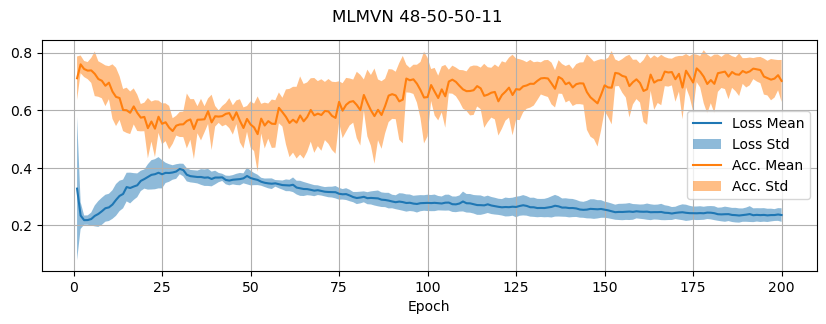

In [ ]:
title = "MLMVN 48-50-50-11"
image_name = "results/MLMVN_48-50-50-11.png"
plot_loss_acc_list(title, list_losses, list_scores, image_name)

In [ ]:
task.mark_completed()
task.close()

### MLMVN [48-100-100-11]

In [ ]:
PATH = str(Path.cwd() / "models/autass-mlmvn_48-100-100-11.pt")

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 100)
        self.phase_act1 = cmplx_phase_activation()
        self.hidden_layer = HiddenLayer(100, 100)
        self.phase_act2 = cmplx_phase_activation()
        self.linear_out = OutputLayer(100, 11)
        self.phase_act3 = cmplx_phase_activation()
        # Hooks
        self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
            self.first_layer_backward_hook
        )
        self.hidden_layer_hook_handle = self.hidden_layer.register_full_backward_hook(
            self.hidden_layer_backward_hook
        )
        self.output_hook_handle = self.linear_out.register_full_backward_hook(
            self.output_layer_backward_hook
        )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.hidden_layer(x)
        x = self.phase_act2(x)
        x = self.linear_out(x)
        x = self.phase_act3(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)
    return losses, scores

In [ ]:
task = Task.init(
    project_name="mlmvn",
    task_name="SDD-mlmvn-[48-100-100-11]",
    tags=["mlmvn", "SDD", "multiple_runs"],
)
writer = SummaryWriter()

#  capture a dictionary of hyperparameters with config
config_dict = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size,
    "optim": "ECL",
    "categories": categories,
    "periodicity": periodicity,
    "layer": "[48-100-100-11]",
}
task.connect(config_dict)

ClearML Task: created new task id=40045a36abde40619f35b7868e1213d1
ClearML results page: http://194.94.231.172:8080/projects/cdefd6ee85454e49be01962ad715eca0/experiments/40045a36abde40619f35b7868e1213d1/output/log


{'learning_rate': 1,
 'epochs': 200,
 'batch_size': 538,
 'optim': 'ECL',
 'categories': 2,
 'periodicity': 1,
 'layer': '[48-100-100-11]'}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_losses = []
list_scores = []
list_acc = []
list_loss = []
list_f1 = []
list_precision = []
list_recall = []

for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )

    model = Model(categories=categories, periodicity=periodicity)
    criterion = ComplexMSELoss.apply
    optimizer = ECL(model.parameters(), lr=lr)

    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    list_scores.append(scores)
    list_losses.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    list_acc.append(acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))
    list_f1.append(
        f1_score(y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0)
    )
    list_precision.append(
        precision_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )
    list_recall.append(
        recall_score(
            y_valid, y_pred.detach().numpy(), average="weighted", zero_division=0
        )
    )

Logger.current_logger().report_single_value(
    name="val_accuracy_mean",
    value=np.mean(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_accuracy_std",
    value=np.std(list_acc),
)
Logger.current_logger().report_single_value(
    name="val_f1_mean",
    value=np.mean(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_f1_std",
    value=np.std(list_f1),
)
Logger.current_logger().report_single_value(
    name="val_precision_mean",
    value=np.mean(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_precision_std",
    value=np.std(list_precision),
)
Logger.current_logger().report_single_value(
    name="val_recall_mean",
    value=np.mean(list_recall),
)
Logger.current_logger().report_single_value(
    name="val_recall_std",
    value=np.std(list_recall),
)

/tmp/ipykernel_1728/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



2022-09-29 15:56:48,669 - clearml.frameworks - INFO - Found existing registered model id=bbd65d869dea4025af46d264d3c7bdee [/home/antonpfeifer/Documents/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-100-100-11.pt] reusing it.
Epoch 9 loss is 0.14245659853440193
Epoch 19 loss is 0.11926958512560476
Epoch 29 loss is 0.10088007783397561
Epoch 39 loss is 0.10160706429771875
Epoch 49 loss is 0.09256600861419079
Epoch 59 loss is 0.10744608628004096
Epoch 69 loss is 0.12774685299619692
Epoch 79 loss is 0.12405285738088577
Epoch 89 loss is 0.12148849057961768
Epoch 99 loss is 0.17548190991717774
Epoch 109 loss is 0.2519070374055556
Epoch 119 loss is 0.29390135104918574
Epoch 129 loss is 0.2631115029064872
Epoch 139 loss is 0.26468762700088244
Epoch 149 loss is 0.2426366788530615
Epoch 159 loss is 0.24249734627332406
Epoch 169 loss is 0.2180138422574741
Epoch 179 loss is 0.1942677829861684
Epoch 189 loss is 0.1656781252246518
Epoch 199 loss is 0.15678583025914528
Train Acc.:  0.91195761317751

/tmp/ipykernel_1728/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.13182902422312057
Epoch 19 loss is 0.10948094408196307
Epoch 29 loss is 0.11030647533056807
Epoch 39 loss is 0.09747520923272845
Epoch 49 loss is 0.10055963818000929
Epoch 59 loss is 0.12781840344883313
Epoch 69 loss is 0.16007342374600603
Epoch 79 loss is 0.2685125349928008
Epoch 89 loss is 0.2605283290643327
Epoch 99 loss is 0.24953134086762976
Epoch 109 loss is 0.26341047064393114
Epoch 119 loss is 0.23938208227294375
Epoch 129 loss is 0.22167797312644905
Epoch 139 loss is 0.19953444239050008
Epoch 149 loss is 0.20466815381159612
Epoch 159 loss is 0.18944607768172028
Epoch 169 loss is 0.17543960927604327
Epoch 179 loss is 0.18857073919083642
Epoch 189 loss is 0.1775085144108209
Epoch 199 loss is 0.1846037562875263
Train Acc.:  0.9090947935137906
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1063
           1       0.89      0.88      0.89      1064
           2       0.99      0.96      0.98      1064
      

/tmp/ipykernel_1728/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.14836475443880184
Epoch 19 loss is 0.1144531471986026
Epoch 29 loss is 0.11196463483836677
Epoch 39 loss is 0.11829244064335528
Epoch 49 loss is 0.2990447238807741
Epoch 59 loss is 0.3416765423666923
Epoch 69 loss is 0.3760340294767417
Epoch 79 loss is 0.3602369454833449
Epoch 89 loss is 0.3415423835663611
Epoch 99 loss is 0.3017989133006243
Epoch 109 loss is 0.2706555786076341
Epoch 119 loss is 0.28536886623172014
Epoch 129 loss is 0.25318045626204816
Epoch 139 loss is 0.23099538649480147
Epoch 149 loss is 0.20753359049453549
Epoch 159 loss is 0.19738129756691591
Epoch 169 loss is 0.17773918197037844
Epoch 179 loss is 0.20320036291560054
Epoch 189 loss is 0.1805354561882004
Epoch 199 loss is 0.16590106544112354
Train Acc.:  0.889482342384686
              precision    recall  f1-score   support

           0       0.97      0.90      0.94      1064
           1       0.91      0.86      0.88      1064
           2       0.97      0.91      0.94      1064
           3

/tmp/ipykernel_1728/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.18644038213906955
Epoch 19 loss is 0.12830064648067416
Epoch 29 loss is 0.16682216144940276
Epoch 39 loss is 0.1759418592172155
Epoch 49 loss is 0.2644686708855199
Epoch 59 loss is 0.3123614077032397
Epoch 69 loss is 0.27872443139031733
Epoch 79 loss is 0.29207407259361867
Epoch 89 loss is 0.2838279987711244
Epoch 99 loss is 0.24346773650683004
Epoch 109 loss is 0.21714146376339183
Epoch 119 loss is 0.19293183048183818
Epoch 129 loss is 0.1947981148247875
Epoch 139 loss is 0.17726155223340453
Epoch 149 loss is 0.20668125270168672
Epoch 159 loss is 0.18338413211908833
Epoch 169 loss is 0.19277969415818375
Epoch 179 loss is 0.16932003069773488
Epoch 189 loss is 0.17114803008451324
Epoch 199 loss is 0.16234674302244245
Train Acc.:  0.872796803896853
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1063
           1       0.87      0.86      0.87      1064
           2       0.97      0.92      0.95      1064
        

/tmp/ipykernel_1728/726702759.py:46: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 9 loss is 0.13195299604718233
Epoch 19 loss is 0.09760398376517222
Epoch 29 loss is 0.09333988532269522
Epoch 39 loss is 0.08521124567492029
Epoch 49 loss is 0.09132043426181803
Epoch 59 loss is 0.09214216010663917
Epoch 69 loss is 0.0896809856068434
Epoch 79 loss is 0.09808253427637235
Epoch 89 loss is 0.1009467307297589
Epoch 99 loss is 0.1341353638423057
Epoch 109 loss is 0.2061791644495565
Epoch 119 loss is 0.26550000244909344
Epoch 129 loss is 0.26717282808322534
Epoch 139 loss is 0.246903110038921
Epoch 149 loss is 0.24215059780955484
Epoch 159 loss is 0.2196847823727955
Epoch 169 loss is 0.22964239756409188
Epoch 179 loss is 0.21456982879325057
Epoch 189 loss is 0.2175676527718779
Epoch 199 loss is 0.20209335012773158
Train Acc.:  0.9208665370564232
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1064
           1       0.93      0.88      0.91      1064
           2       0.98      0.95      0.96      1064
          

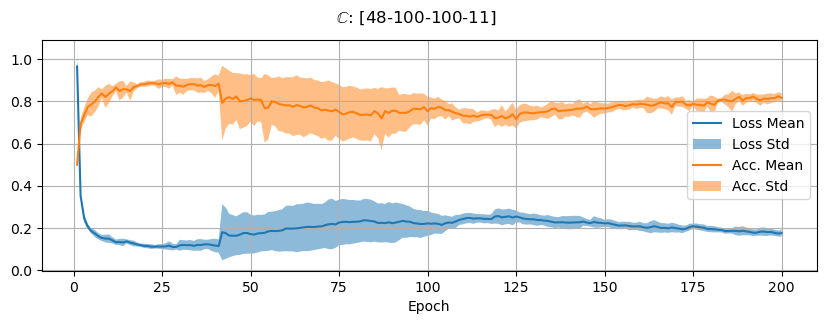

In [ ]:
# title = "MLMVN 48-100-100-11"
# image_name = "results/MLMVN_48-100-100-11.png"
# plot_loss_acc_list(title, list_losses, list_scores, image_name)
plot_loss_acc_list(
    "$\mathbb{C}$: [48-100-100-11] ",
    list_losses,
    list_scores,
    "mlmvn-48-100-100-11.png",
)

In [ ]:
task.mark_completed()
task.close()